In [1]:
%reload_ext autoreload
%autoreload 3

import matplotlib.pyplot as plt


In [2]:
%script echo skipping...
# webview

import cortex
cortex.webshow(cortex.Volume.random("S1", "fullhead"))

In [3]:
%script echo skipping...

# left, right = cortex.db.S1.surfaces.inflated.get()
# cortex.db.S1.surfaces.flat.show()

In [ ]:
%script echo skipping...

import cortex

subject = "S1"
xfm = "fullhead"
roi = "EBA"

# Get the map of which voxels are inside of our ROI
roi_masks = cortex.utils.get_roi_masks(subject, xfm,
                                       roi_list=[roi],
                                       gm_sampler='cortical-conservative', # Select only voxels mostly within cortex
                                       split_lr=False, # No separate left/right ROIs
                                       threshold=None, # Leave roi mask values as probabilites / fractions
                                       return_dict=True
                                       )

# # Plot the mask for one ROI onto a flatmap
roi_data = cortex.Volume(roi_masks[roi], subject, xfm,
                         vmin=0, # This is a probability mask, so only
                         vmax=1, # so scale btw zero and one
                         cmap="inferno", # For pretty
                         )

cortex.quickflat.make_figure(roi_data,
                             thick=1, # select a single depth (btw white matter & pia)
                             sampler='nearest', # no interpolation
                             with_curvature=False,
                             with_colorbar=True,
                             )

plt.show()

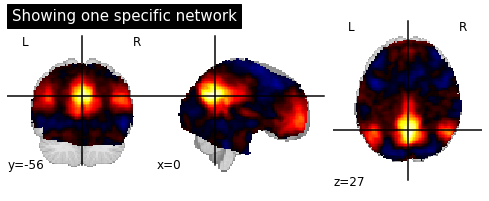

In [ ]:
%script echo skipping...

from nilearn import datasets
from nilearn import plotting, image

smith_atlas = datasets.fetch_atlas_smith_2009()
rsn10_img = smith_atlas.rsn10

img = image.index_img(rsn10_img, 3)

coords = plotting.find_xyz_cut_coords(img)
coords

# display = plotting.plot_anat(cut_coords=coords,
#                              title='Regions from this network')

display = plotting.plot_stat_map(img, cut_coords=coords, colorbar=False,
                                 title='Showing one specific network')
# display.add_overlay(img,
#                     cmap=plotting.cm.alpha_cmap('r'))

plotting.show()

/usr/local/Caskroom/miniforge/base/envs/acnets/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


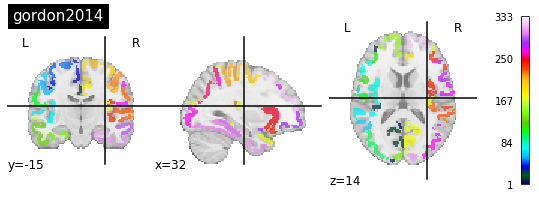

In [5]:
from nilearn import datasets, plotting, image

import matplotlib.pyplot as plt

from python.acnets.parcellations.gordon  import fetch_atlas as fetch_gordon2014_atlas
gordon2014_atlas = fetch_gordon2014_atlas()
# plotting.plot_roi(atlas.maps, title='atlas', colorbar=True)

# atlas = datasets.fetch_atlas_difumo()
# plotting.plot_img(image.load_img(atlas.maps).slicer[...,1])

plotting.plot_roi(gordon2014_atlas.maps, title='gordon2014', colorbar=True)

plt.show()

/usr/local/Caskroom/miniforge/base/envs/acnets/lib/python3.9/site-packages/nilearn/image/image.py:756: FutureWarning: Image data has type int64, which may cause incompatibilities with other tools. This will error in NiBabel 5.0. This warning can be silenced by passing the dtype argument to Nifti1Image().
  return klass(data, affine, header=header)


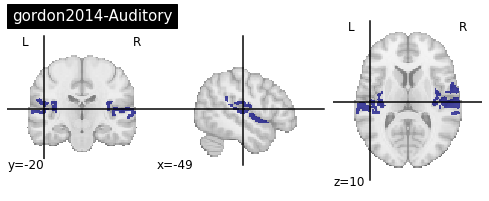

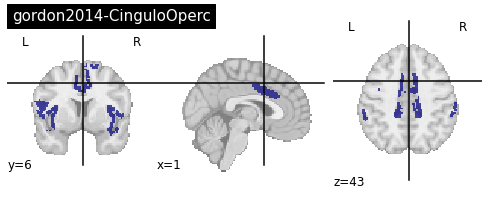

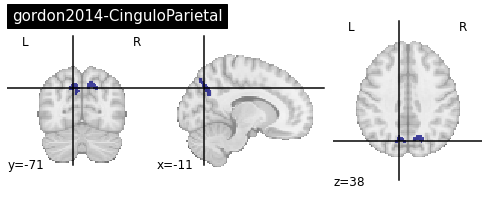

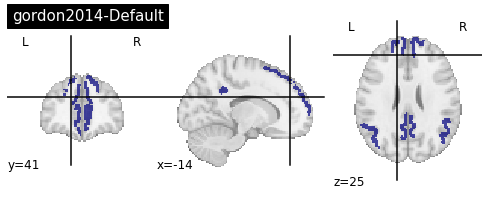

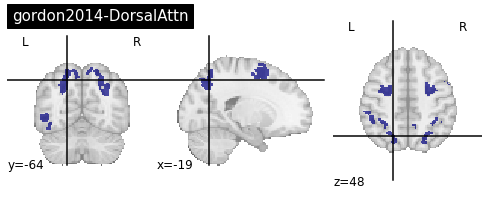

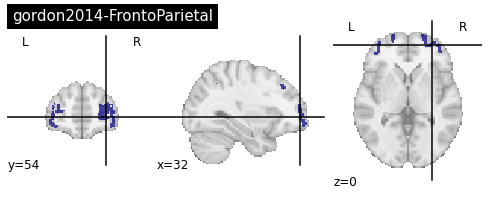

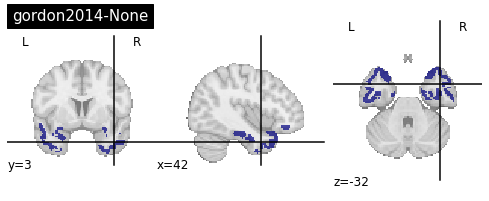

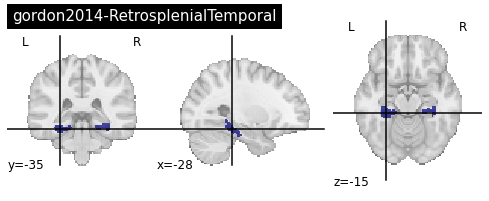

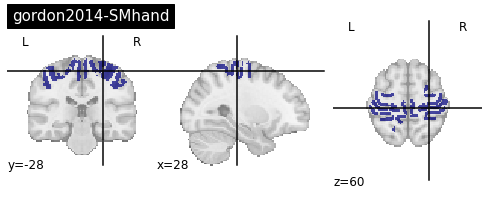

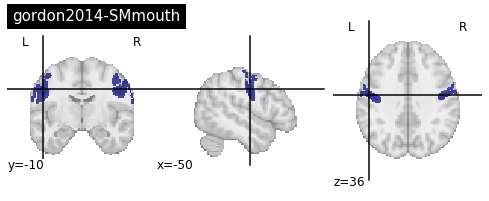

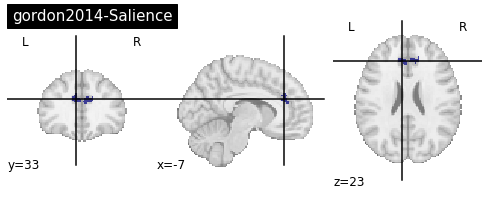

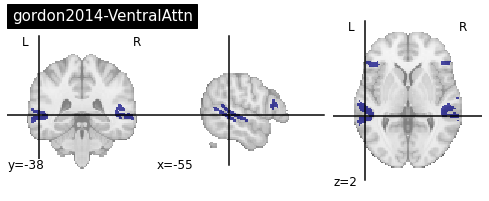

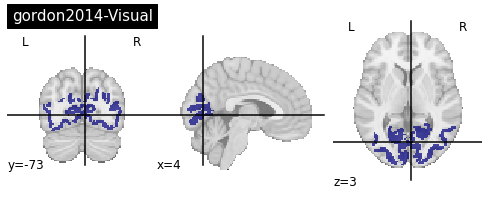

In [438]:
import numpy as np
network_map = image.load_img(gordon2014_atlas.maps).get_fdata().squeeze()
# network_map.max()
gordon_labels = gordon2014_atlas.labels.reset_index()
gordon_labels['network_index'] = gordon_labels['network'].astype('category').cat.codes + 1

network_names = gordon_labels.network.astype('category').cat.categories.to_list()

def reg2net_func(region_index):
    net_index = 0
    if region_index > 0:
        net_index =  gordon_labels[['network_index']].values[int(region_index)-1,0].astype('float')

    return net_index

network_map = np.vectorize(reg2net_func)(network_map)
network_map = network_map[..., np.newaxis]

print('now plotting networks...')

for i in range(1, network_map.max()+1):
    single_network_map = np.where(network_map == i, network_map, 0)
    network_img = image.new_img_like(gordon2014_atlas.maps, single_network_map)

    title = f'gordon2014-{network_names[i-1]}'
    # display = plotting.plot_glass_brain(network_img,
    #                                     title=title, colorbar=False, annotate=True)
    display = plotting.plot_roi(network_img,
                                title=title, colorbar=False, annotate=True)

    plt.show()

extracting regions...
now plotting...


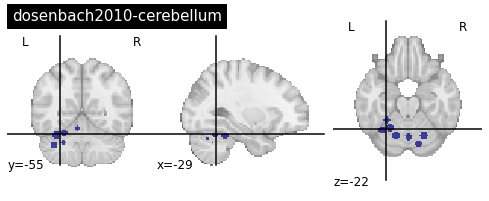

extracting regions...
now plotting...


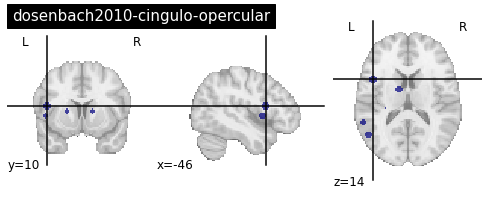

extracting regions...
now plotting...


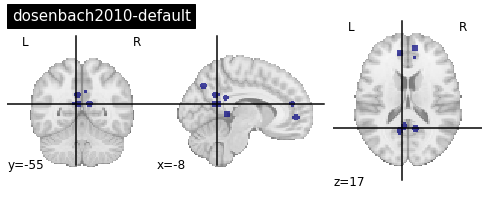

extracting regions...
now plotting...


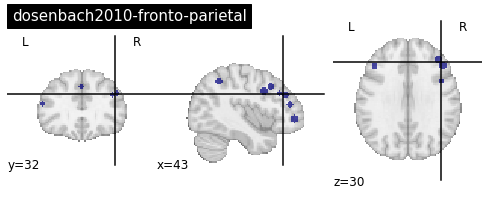

extracting regions...
now plotting...


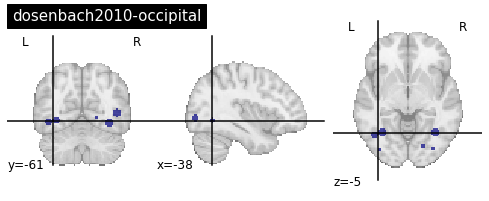

extracting regions...
now plotting...


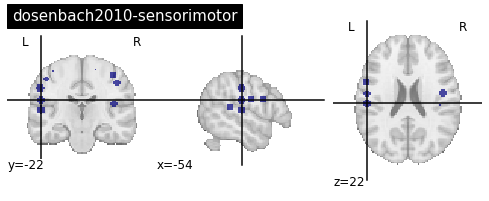

""


In [435]:
from nilearn import datasets, maskers
from nilearn.maskers.nifti_spheres_masker import _apply_mask_and_get_affinity
from python.acnets.parcellations.dosenbach import load_dosenbach2010_masker

_, labels = load_dosenbach2010_masker()

labels = labels.reset_index().drop(columns=['index'])

from nilearn.datasets import load_mni152_template

mni152_template = load_mni152_template(resolution=2)
mni152_data = mni152_template.get_fdata()[..., np.newaxis]
mni152_template = image.new_img_like(mni152_template, mni152_data)

def create_network_mask(regions, mni152=mni152_template):
    network_name = regions.name
    seeds = regions[['x','y','z']].values

    print('extracting regions...')

    _, A = _apply_mask_and_get_affinity(seeds, mni152, radius=5, allow_overlap=False)
    _img = A.toarray().sum(axis=0).reshape(mni152.shape)
    _img = image.new_img_like(mni152, _img)

    print('now plotting...')

    title = f'dosenbach2010-{network_name}'
    plotting.plot_roi(_img, title=title, colorbar=False)
    plt.show()


labels.groupby('network').apply(lambda regions: create_network_mask(regions))